# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2_matrix


2022-10-15_20-21-051i6ubnd9  train-152633_0.slurm.err  train-152633_2.slurm.out
2022-10-15_20-21-055x1s5ecg  train-152633_0.slurm.out  train-152633_3.slurm.err
2022-10-15_20-21-05l2jrttu4  train-152633_1.slurm.err  train-152633_3.slurm.out
2022-10-15_20-21-05n2r125tc  train-152633_1.slurm.out  train-152633_4.slurm.err
2022-10-15_20-21-05zvlbcbhk  train-152633_2.slurm.err  train-152633_4.slurm.out


In [8]:
!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10


2022-10-17_16-01-13dqqjntxb  train-191269_0.slurm.err  train-191269_2.slurm.out
2022-10-17_16-01-142pvfn2tk  train-191269_0.slurm.out  train-191269_3.slurm.err
2022-10-17_16-01-14bfynpbi7  train-191269_1.slurm.err  train-191269_3.slurm.out
2022-10-17_16-01-16o1m32xxn  train-191269_1.slurm.out  train-191269_4.slurm.err
2022-10-17_16-01-16s4p4yg8u  train-191269_2.slurm.err  train-191269_4.slurm.out


In [9]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
#environment = PopGoalLinesEnv

# 6 landmarks
config_file = "large_goal_lines_naming.yml"
environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb"

In [12]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-18 22:33:20,643	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-18 22:33:20,643	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-18 22:33:20,644	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-18 22:33:20,644	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-18 22:33:20,645	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-18 22:33:20,652	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-18 22:33:20,668	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-18 22:33:20,675	WARNING util.py:65 -- Install gputil for GPU system monitoring.


# Inspecting matrices through time

2022-10-18 22:44:31,487	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000010/checkpoint-10
2022-10-18 22:44:31,492	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 622.1854975223541, '_episodes_total': 1206}


checkpoint-10
checkpoint-20


2022-10-18 22:44:31,722	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000020/checkpoint-20
2022-10-18 22:44:31,723	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1241.296260356903, '_episodes_total': 2474}
2022-10-18 22:44:32,217	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000030/checkpoint-30
2022-10-18 22:44:32,221	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1848.3339257240295, '_episodes_total': 3807}


checkpoint-30


2022-10-18 22:44:32,488	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000040/checkpoint-40
2022-10-18 22:44:32,489	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2460.4450199604034, '_episodes_total': 5318}


checkpoint-40


2022-10-18 22:44:32,759	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000050/checkpoint-50
2022-10-18 22:44:32,760	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 3059.2073335647583, '_episodes_total': 6970}


checkpoint-50


2022-10-18 22:44:33,034	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000060/checkpoint-60
2022-10-18 22:44:33,034	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3647.7612476348877, '_episodes_total': 8930}


checkpoint-60


2022-10-18 22:44:33,306	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000070/checkpoint-70
2022-10-18 22:44:33,307	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4224.943605899811, '_episodes_total': 10969}


checkpoint-70


2022-10-18 22:44:33,581	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000080/checkpoint-80
2022-10-18 22:44:33,581	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4783.658557891846, '_episodes_total': 13151}


checkpoint-80


2022-10-18 22:44:33,850	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000090/checkpoint-90
2022-10-18 22:44:33,852	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5336.438555717468, '_episodes_total': 15321}


checkpoint-90


2022-10-18 22:44:34,122	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000100/checkpoint-100
2022-10-18 22:44:34,124	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5877.147433519363, '_episodes_total': 17449}


checkpoint-100


2022-10-18 22:44:34,395	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000110/checkpoint-110
2022-10-18 22:44:34,395	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 6404.209262609482, '_episodes_total': 19662}


checkpoint-110


2022-10-18 22:44:34,650	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000120/checkpoint-120
2022-10-18 22:44:34,650	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6911.66018819809, '_episodes_total': 22234}


checkpoint-120


2022-10-18 22:44:34,850	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000130/checkpoint-130
2022-10-18 22:44:34,851	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 7406.510012626648, '_episodes_total': 24945}


checkpoint-130
checkpoint-140


2022-10-18 22:44:35,117	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000140/checkpoint-140
2022-10-18 22:44:35,118	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7896.8038647174835, '_episodes_total': 27792}
2022-10-18 22:44:35,392	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000150/checkpoint-150
2022-10-18 22:44:35,393	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 8371.549973726273, '_episodes_total': 30640}


checkpoint-150


2022-10-18 22:44:35,643	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000160/checkpoint-160
2022-10-18 22:44:35,644	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8847.54684138298, '_episodes_total': 33592}


checkpoint-160


2022-10-18 22:44:35,888	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000170/checkpoint-170
2022-10-18 22:44:35,890	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 9323.006983041763, '_episodes_total': 36555}


checkpoint-170


2022-10-18 22:44:36,163	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000180/checkpoint-180
2022-10-18 22:44:36,163	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9791.285125017166, '_episodes_total': 39605}


checkpoint-180


2022-10-18 22:44:36,432	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000190/checkpoint-190
2022-10-18 22:44:36,433	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 10255.224375724792, '_episodes_total': 42598}


checkpoint-190


2022-10-18 22:44:36,636	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000200/checkpoint-200
2022-10-18 22:44:36,636	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10708.875116109848, '_episodes_total': 45275}


checkpoint-200


2022-10-18 22:44:37,115	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000210/checkpoint-210
2022-10-18 22:44:37,116	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11164.83686542511, '_episodes_total': 48215}


checkpoint-210


2022-10-18 22:44:37,392	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000220/checkpoint-220
2022-10-18 22:44:37,396	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 11622.360967874527, '_episodes_total': 51514}


checkpoint-220


2022-10-18 22:44:37,668	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000230/checkpoint-230
2022-10-18 22:44:37,669	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 12080.670796871185, '_episodes_total': 55081}


checkpoint-230


2022-10-18 22:44:37,869	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000240/checkpoint-240
2022-10-18 22:44:37,870	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12540.276618480682, '_episodes_total': 58766}


checkpoint-240


2022-10-18 22:44:38,151	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000250/checkpoint-250
2022-10-18 22:44:38,151	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 13005.835154533386, '_episodes_total': 63594}


checkpoint-250


2022-10-18 22:44:38,421	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000260/checkpoint-260
2022-10-18 22:44:38,424	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 13471.187633514404, '_episodes_total': 68595}


checkpoint-260


2022-10-18 22:44:38,697	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000270/checkpoint-270
2022-10-18 22:44:38,698	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 13934.617867469788, '_episodes_total': 73760}


checkpoint-270


2022-10-18 22:44:38,971	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000280/checkpoint-280
2022-10-18 22:44:38,972	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 14397.941051244736, '_episodes_total': 78995}


checkpoint-280


2022-10-18 22:44:39,173	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000290/checkpoint-290
2022-10-18 22:44:39,174	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 14863.454620361328, '_episodes_total': 84479}


checkpoint-290


2022-10-18 22:44:39,445	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000300/checkpoint-300
2022-10-18 22:44:39,447	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 15326.705296278, '_episodes_total': 90764}


checkpoint-300


2022-10-18 22:44:39,651	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000310/checkpoint-310
2022-10-18 22:44:39,651	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 15785.069763422012, '_episodes_total': 97442}


checkpoint-310


2022-10-18 22:44:39,929	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000320/checkpoint-320
2022-10-18 22:44:39,934	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 16245.434670209885, '_episodes_total': 104525}


checkpoint-320


2022-10-18 22:44:40,208	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000330/checkpoint-330
2022-10-18 22:44:40,210	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 16707.883613586426, '_episodes_total': 111673}


checkpoint-330


2022-10-18 22:44:40,483	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000340/checkpoint-340
2022-10-18 22:44:40,484	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 17171.890023708344, '_episodes_total': 118977}


checkpoint-340


2022-10-18 22:44:40,761	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000350/checkpoint-350
2022-10-18 22:44:40,763	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 17632.637137651443, '_episodes_total': 126461}


checkpoint-350


2022-10-18 22:44:40,963	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000360/checkpoint-360
2022-10-18 22:44:40,966	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 18090.657535791397, '_episodes_total': 134074}


checkpoint-360


2022-10-18 22:44:41,242	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000370/checkpoint-370
2022-10-18 22:44:41,243	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 370, '_timesteps_total': None, '_time_total': 18546.347626924515, '_episodes_total': 141761}


checkpoint-370


2022-10-18 22:44:41,722	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000380/checkpoint-380
2022-10-18 22:44:41,722	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 19001.642100572586, '_episodes_total': 149601}


checkpoint-380


2022-10-18 22:44:41,923	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000390/checkpoint-390
2022-10-18 22:44:41,928	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 19456.8801984787, '_episodes_total': 157360}


checkpoint-390


2022-10-18 22:44:42,202	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000400/checkpoint-400
2022-10-18 22:44:42,203	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 19914.35753273964, '_episodes_total': 165385}


checkpoint-400


2022-10-18 22:44:42,482	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000410/checkpoint-410
2022-10-18 22:44:42,486	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 20370.71174645424, '_episodes_total': 173094}


checkpoint-410


2022-10-18 22:44:42,759	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000420/checkpoint-420
2022-10-18 22:44:42,760	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 20826.413417577744, '_episodes_total': 181297}


checkpoint-420


2022-10-18 22:44:42,959	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000430/checkpoint-430
2022-10-18 22:44:42,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 430, '_timesteps_total': None, '_time_total': 21281.796070098877, '_episodes_total': 189469}


checkpoint-430


2022-10-18 22:44:43,163	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000440/checkpoint-440
2022-10-18 22:44:43,169	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 21737.972167253494, '_episodes_total': 197818}


checkpoint-440


2022-10-18 22:44:43,445	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000450/checkpoint-450
2022-10-18 22:44:43,446	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': None, '_time_total': 22193.91540646553, '_episodes_total': 206203}


checkpoint-450


2022-10-18 22:44:43,713	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000460/checkpoint-460
2022-10-18 22:44:43,714	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 22663.809248685837, '_episodes_total': 215595}


checkpoint-460


2022-10-18 22:44:43,983	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000470/checkpoint-470
2022-10-18 22:44:43,984	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 23153.392374038696, '_episodes_total': 226769}


checkpoint-470


2022-10-18 22:44:44,203	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000480/checkpoint-480
2022-10-18 22:44:44,204	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 23644.64689016342, '_episodes_total': 239278}


checkpoint-480


2022-10-18 22:44:44,408	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000490/checkpoint-490
2022-10-18 22:44:44,409	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 490, '_timesteps_total': None, '_time_total': 24137.880802631378, '_episodes_total': 252359}


checkpoint-490


2022-10-18 22:44:44,686	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000500/checkpoint-500
2022-10-18 22:44:44,686	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 24629.699470758438, '_episodes_total': 265803}


checkpoint-500


2022-10-18 22:44:44,955	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000510/checkpoint-510
2022-10-18 22:44:44,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 510, '_timesteps_total': None, '_time_total': 25123.580305337906, '_episodes_total': 279528}


checkpoint-510


2022-10-18 22:44:45,159	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000520/checkpoint-520
2022-10-18 22:44:45,163	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 25617.223092556, '_episodes_total': 293466}


checkpoint-520


2022-10-18 22:44:45,430	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000530/checkpoint-530
2022-10-18 22:44:45,431	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 26112.215538740158, '_episodes_total': 307550}


checkpoint-530


2022-10-18 22:44:45,708	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000540/checkpoint-540
2022-10-18 22:44:45,709	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 26606.756949663162, '_episodes_total': 321777}


checkpoint-540


2022-10-18 22:44:45,939	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000550/checkpoint-550
2022-10-18 22:44:45,940	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 550, '_timesteps_total': None, '_time_total': 27102.387250185013, '_episodes_total': 336095}


checkpoint-550


2022-10-18 22:44:46,421	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000560/checkpoint-560
2022-10-18 22:44:46,422	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 27597.295079231262, '_episodes_total': 350401}


checkpoint-560


2022-10-18 22:44:46,691	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000570/checkpoint-570
2022-10-18 22:44:46,692	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': None, '_time_total': 28092.18595123291, '_episodes_total': 364753}


checkpoint-570


2022-10-18 22:44:46,963	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000580/checkpoint-580
2022-10-18 22:44:46,964	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 28586.86480975151, '_episodes_total': 379153}


checkpoint-580


2022-10-18 22:44:47,225	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000590/checkpoint-590
2022-10-18 22:44:47,226	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 29082.32865834236, '_episodes_total': 393621}


checkpoint-590


2022-10-18 22:44:47,530	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000600/checkpoint-600
2022-10-18 22:44:47,531	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 29577.35481595993, '_episodes_total': 408187}


checkpoint-600


2022-10-18 22:44:47,824	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000610/checkpoint-610
2022-10-18 22:44:47,824	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 610, '_timesteps_total': None, '_time_total': 30125.209369421005, '_episodes_total': 422743}


checkpoint-610


2022-10-18 22:44:48,023	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000620/checkpoint-620
2022-10-18 22:44:48,029	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 30620.97071290016, '_episodes_total': 437320}


checkpoint-620


2022-10-18 22:44:48,300	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000630/checkpoint-630
2022-10-18 22:44:48,301	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 630, '_timesteps_total': None, '_time_total': 31115.577355623245, '_episodes_total': 451876}


checkpoint-630


2022-10-18 22:44:48,572	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000640/checkpoint-640
2022-10-18 22:44:48,574	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 31611.009486198425, '_episodes_total': 466585}


checkpoint-640


2022-10-18 22:44:48,811	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000650/checkpoint-650
2022-10-18 22:44:48,813	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 32105.822902202606, '_episodes_total': 481271}


checkpoint-650


2022-10-18 22:44:49,080	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000660/checkpoint-660
2022-10-18 22:44:49,081	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 32600.216778993607, '_episodes_total': 495953}


checkpoint-660


2022-10-18 22:44:49,355	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000670/checkpoint-670
2022-10-18 22:44:49,355	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 670, '_timesteps_total': None, '_time_total': 33094.92776918411, '_episodes_total': 510659}


checkpoint-670


2022-10-18 22:44:49,562	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000680/checkpoint-680
2022-10-18 22:44:49,563	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 33590.61056661606, '_episodes_total': 525427}


checkpoint-680


2022-10-18 22:44:49,842	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000690/checkpoint-690
2022-10-18 22:44:49,842	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 34085.81555342674, '_episodes_total': 540180}


checkpoint-690


2022-10-18 22:44:50,049	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000700/checkpoint-700
2022-10-18 22:44:50,049	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 34580.83529376984, '_episodes_total': 554897}


checkpoint-700


2022-10-18 22:44:50,313	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000710/checkpoint-710
2022-10-18 22:44:50,314	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 710, '_timesteps_total': None, '_time_total': 35075.8815202713, '_episodes_total': 569714}


checkpoint-710


2022-10-18 22:44:50,588	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000720/checkpoint-720
2022-10-18 22:44:50,589	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 35571.15254831314, '_episodes_total': 584516}


checkpoint-720


2022-10-18 22:44:51,077	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000730/checkpoint-730
2022-10-18 22:44:51,077	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 730, '_timesteps_total': None, '_time_total': 36066.07223582268, '_episodes_total': 599337}


checkpoint-730


2022-10-18 22:44:51,353	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000740/checkpoint-740
2022-10-18 22:44:51,355	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 36561.27767658234, '_episodes_total': 614149}


checkpoint-740


2022-10-18 22:44:51,621	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000750/checkpoint-750
2022-10-18 22:44:51,622	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 37057.77058792114, '_episodes_total': 629011}


checkpoint-750


2022-10-18 22:44:51,819	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000760/checkpoint-760
2022-10-18 22:44:51,820	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 37553.80152750015, '_episodes_total': 643809}


checkpoint-760
checkpoint-770


2022-10-18 22:44:52,089	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000770/checkpoint-770
2022-10-18 22:44:52,090	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 770, '_timesteps_total': None, '_time_total': 38049.976702690125, '_episodes_total': 658567}
2022-10-18 22:44:52,324	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000780/checkpoint-780
2022-10-18 22:44:52,325	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 38544.77285528183, '_episodes_total': 673324}


checkpoint-780


2022-10-18 22:44:52,522	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000790/checkpoint-790
2022-10-18 22:44:52,525	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 790, '_timesteps_total': None, '_time_total': 39039.26917910576, '_episodes_total': 688178}


checkpoint-790
checkpoint-800


2022-10-18 22:44:52,798	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000800/checkpoint-800
2022-10-18 22:44:52,799	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 39535.39530444145, '_episodes_total': 703059}
2022-10-18 22:44:53,072	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000810/checkpoint-810
2022-10-18 22:44:53,072	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 40031.140689373016, '_episodes_total': 717924}


checkpoint-810


2022-10-18 22:44:53,338	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000820/checkpoint-820
2022-10-18 22:44:53,340	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 40531.12103700638, '_episodes_total': 732788}


checkpoint-820


2022-10-18 22:44:53,613	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000830/checkpoint-830
2022-10-18 22:44:53,615	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 830, '_timesteps_total': None, '_time_total': 41026.735517024994, '_episodes_total': 747717}


checkpoint-830


2022-10-18 22:44:53,887	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000840/checkpoint-840
2022-10-18 22:44:53,888	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 41522.42910528183, '_episodes_total': 762684}


checkpoint-840


2022-10-18 22:44:54,106	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000850/checkpoint-850
2022-10-18 22:44:54,110	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 850, '_timesteps_total': None, '_time_total': 42017.53998374939, '_episodes_total': 777636}


checkpoint-850


2022-10-18 22:44:54,320	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000860/checkpoint-860
2022-10-18 22:44:54,320	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 42512.83485364914, '_episodes_total': 792599}


checkpoint-860


2022-10-18 22:44:54,617	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000870/checkpoint-870
2022-10-18 22:44:54,620	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 43008.792739868164, '_episodes_total': 807543}


checkpoint-870


2022-10-18 22:44:54,831	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000880/checkpoint-880
2022-10-18 22:44:54,832	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 43504.087676763535, '_episodes_total': 822456}


checkpoint-880


2022-10-18 22:44:55,037	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000890/checkpoint-890
2022-10-18 22:44:55,041	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 890, '_timesteps_total': None, '_time_total': 43999.61808490753, '_episodes_total': 837372}


checkpoint-890


2022-10-18 22:44:55,315	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000900/checkpoint-900
2022-10-18 22:44:55,316	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 44494.98359489441, '_episodes_total': 852328}


checkpoint-900


2022-10-18 22:44:55,732	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000910/checkpoint-910
2022-10-18 22:44:55,732	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 910, '_timesteps_total': None, '_time_total': 44990.23669028282, '_episodes_total': 867295}


checkpoint-910


2022-10-18 22:44:56,003	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000920/checkpoint-920
2022-10-18 22:44:56,008	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 45486.60538864136, '_episodes_total': 882274}


checkpoint-920


2022-10-18 22:44:56,210	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000930/checkpoint-930
2022-10-18 22:44:56,212	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 45981.3763988018, '_episodes_total': 897229}


checkpoint-930


2022-10-18 22:44:56,471	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000940/checkpoint-940
2022-10-18 22:44:56,472	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 46477.09857439995, '_episodes_total': 912223}


checkpoint-940


2022-10-18 22:44:56,744	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000950/checkpoint-950
2022-10-18 22:44:56,746	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 950, '_timesteps_total': None, '_time_total': 46972.00146603584, '_episodes_total': 927215}


checkpoint-950


2022-10-18 22:44:57,008	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000960/checkpoint-960
2022-10-18 22:44:57,009	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 47466.35207390785, '_episodes_total': 942160}


checkpoint-960


2022-10-18 22:44:57,279	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000970/checkpoint-970
2022-10-18 22:44:57,281	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 970, '_timesteps_total': None, '_time_total': 47961.33977437019, '_episodes_total': 957200}


checkpoint-970


2022-10-18 22:44:57,550	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000980/checkpoint-980
2022-10-18 22:44:57,551	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 48456.50708055496, '_episodes_total': 972180}


checkpoint-980


2022-10-18 22:44:57,820	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_000990/checkpoint-990
2022-10-18 22:44:57,822	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 48951.163098335266, '_episodes_total': 987168}


checkpoint-990


2022-10-18 22:44:58,087	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001000/checkpoint-1000
2022-10-18 22:44:58,089	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 49446.28534078598, '_episodes_total': 1002198}


checkpoint-1000


2022-10-18 22:44:58,360	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001010/checkpoint-1010
2022-10-18 22:44:58,360	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1010, '_timesteps_total': None, '_time_total': 49942.35276198387, '_episodes_total': 1017233}


checkpoint-1010


2022-10-18 22:44:58,604	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001020/checkpoint-1020
2022-10-18 22:44:58,605	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1020, '_timesteps_total': None, '_time_total': 50437.82317566872, '_episodes_total': 1032169}


checkpoint-1020


2022-10-18 22:44:58,843	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001030/checkpoint-1030
2022-10-18 22:44:58,843	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1030, '_timesteps_total': None, '_time_total': 50934.20672893524, '_episodes_total': 1047203}


checkpoint-1030


2022-10-18 22:44:59,113	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001040/checkpoint-1040
2022-10-18 22:44:59,117	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1040, '_timesteps_total': None, '_time_total': 51429.99682235718, '_episodes_total': 1062237}


checkpoint-1040


2022-10-18 22:44:59,397	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001050/checkpoint-1050
2022-10-18 22:44:59,398	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1050, '_timesteps_total': None, '_time_total': 51925.62357187271, '_episodes_total': 1077248}


checkpoint-1050


2022-10-18 22:44:59,605	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001060/checkpoint-1060
2022-10-18 22:44:59,605	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1060, '_timesteps_total': None, '_time_total': 52421.18560004234, '_episodes_total': 1092232}


checkpoint-1060


2022-10-18 22:44:59,881	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001070/checkpoint-1070
2022-10-18 22:44:59,881	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1070, '_timesteps_total': None, '_time_total': 52917.872151851654, '_episodes_total': 1107255}


checkpoint-1070


2022-10-18 22:45:00,080	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001080/checkpoint-1080
2022-10-18 22:45:00,082	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1080, '_timesteps_total': None, '_time_total': 53413.18450307846, '_episodes_total': 1122229}


checkpoint-1080


2022-10-18 22:45:00,525	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001090/checkpoint-1090
2022-10-18 22:45:00,526	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1090, '_timesteps_total': None, '_time_total': 53909.06731200218, '_episodes_total': 1137278}


checkpoint-1090


2022-10-18 22:45:00,799	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001100/checkpoint-1100
2022-10-18 22:45:00,800	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1100, '_timesteps_total': None, '_time_total': 54403.95703434944, '_episodes_total': 1152299}


checkpoint-1100


2022-10-18 22:45:01,073	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001110/checkpoint-1110
2022-10-18 22:45:01,074	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1110, '_timesteps_total': None, '_time_total': 54899.32789349556, '_episodes_total': 1167323}


checkpoint-1110


2022-10-18 22:45:01,277	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001120/checkpoint-1120
2022-10-18 22:45:01,282	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1120, '_timesteps_total': None, '_time_total': 55394.84303021431, '_episodes_total': 1182382}


checkpoint-1120


2022-10-18 22:45:01,562	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001130/checkpoint-1130
2022-10-18 22:45:01,562	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1130, '_timesteps_total': None, '_time_total': 55890.07947611809, '_episodes_total': 1197399}


checkpoint-1130


2022-10-18 22:45:01,768	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001140/checkpoint-1140
2022-10-18 22:45:01,770	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1140, '_timesteps_total': None, '_time_total': 56385.383424043655, '_episodes_total': 1212464}


checkpoint-1140


2022-10-18 22:45:02,039	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001150/checkpoint-1150
2022-10-18 22:45:02,040	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1150, '_timesteps_total': None, '_time_total': 56884.743609666824, '_episodes_total': 1227543}


checkpoint-1150


2022-10-18 22:45:02,308	INFO trainable.py:588 -- Restored on 10.159.12.193 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg_t30_a10/2022-10-17_16-01-13dqqjntxb/checkpoint_001160/checkpoint-1160
2022-10-18 22:45:02,309	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1160, '_timesteps_total': None, '_time_total': 57380.867405653, '_episodes_total': 1242549}


checkpoint-1160


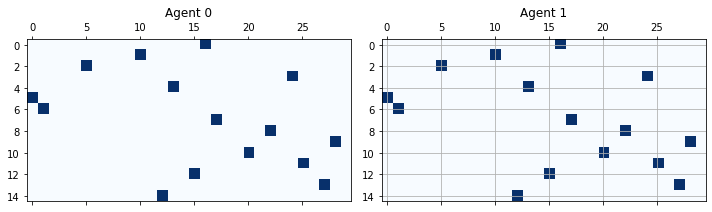

In [23]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [18]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [19]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()

In [10]:
matrix_video = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(imgs, fps=0.5)

matrix_video.write_videofile(os.path.join(checkpoints_dir, "naming_game.mp4"))

Moviepy - Building video /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4.
Moviepy - Writing video /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4



Moviepy - Done !
Moviepy - video ready /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4


# 2 matrix

In [13]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = population.LARGE_GOAL_LINES_TIMELIMIT
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork", FullNamingNetwork)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
    },
}
trainer = FullNamingTrainer(
    config=config,
    env=train_env,
)

2022-10-17 14:55:47,202	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-17 14:55:47,205	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,211	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-17 14:55:47,240	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-17 14:55:47,248	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [ ]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._leader_matrix.numpy()
            agent_1_matrix = agent_1._follower_matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(number_of_goals):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    